In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt
import datetime as dt
import itertools

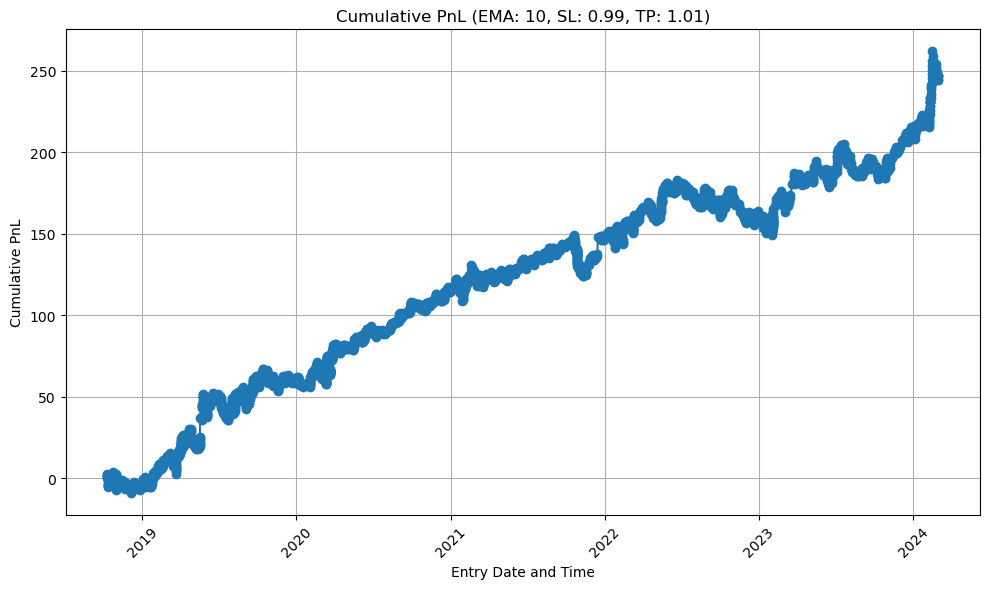

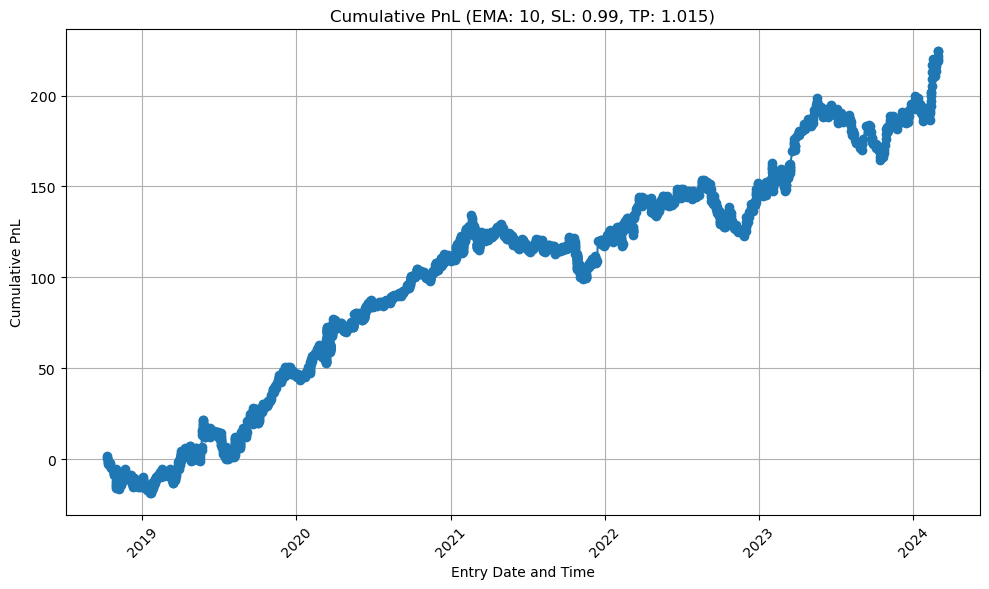

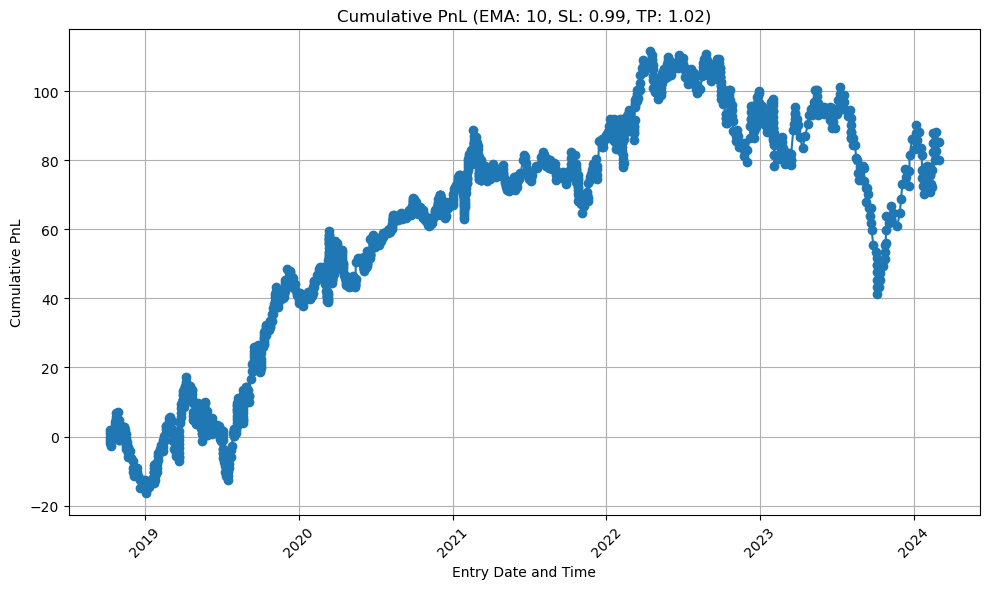

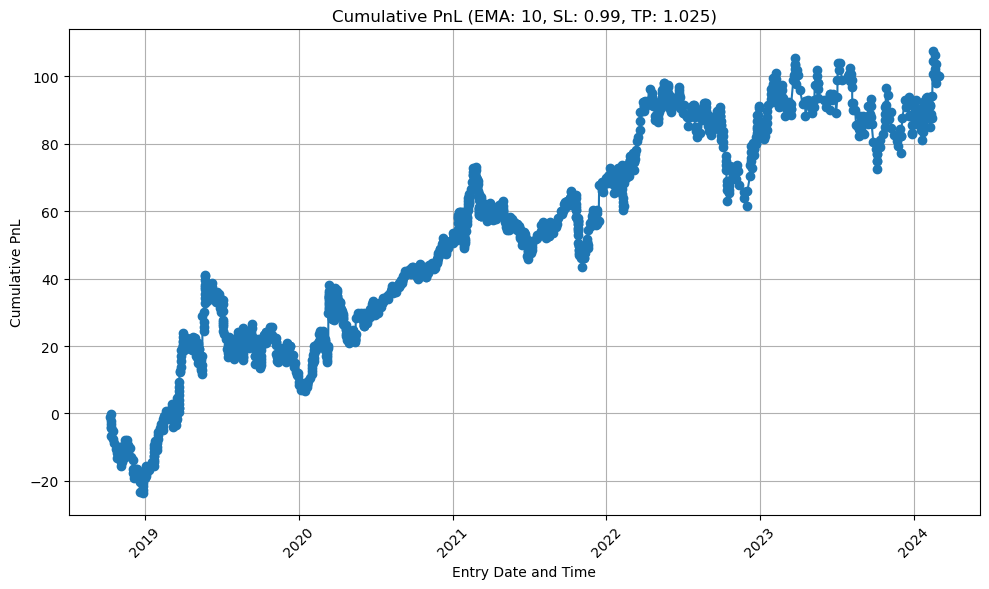

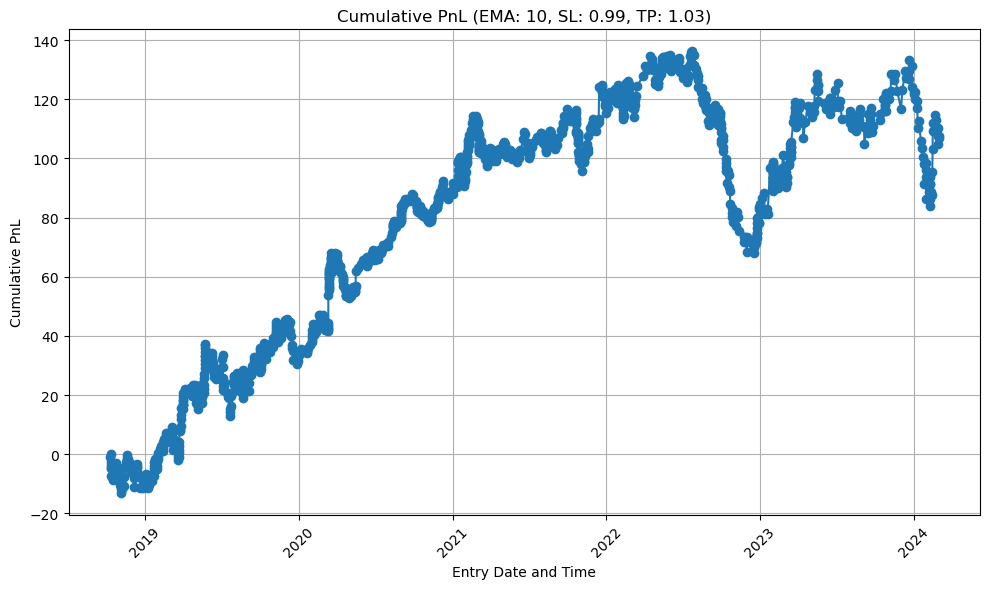

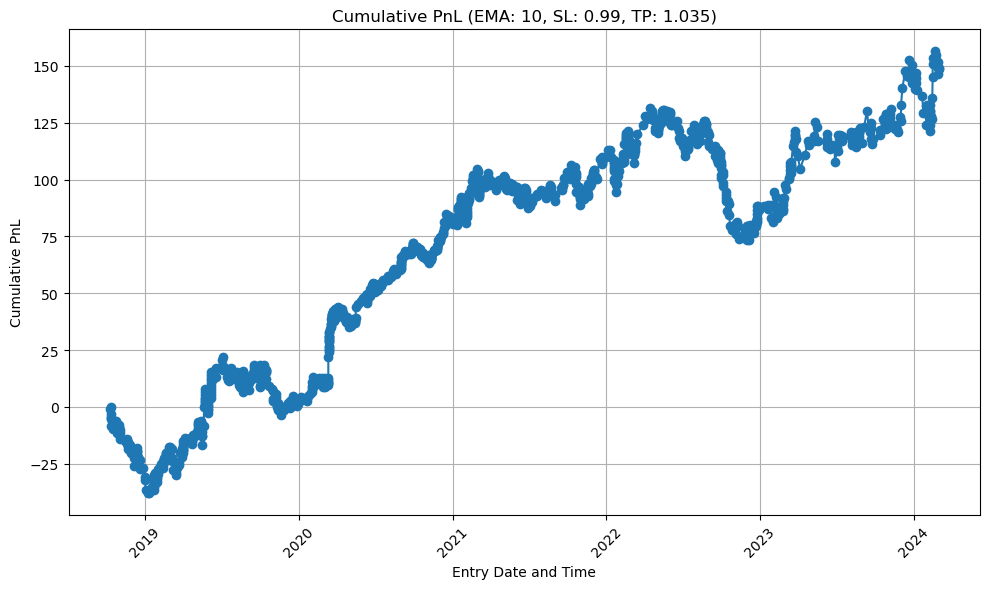

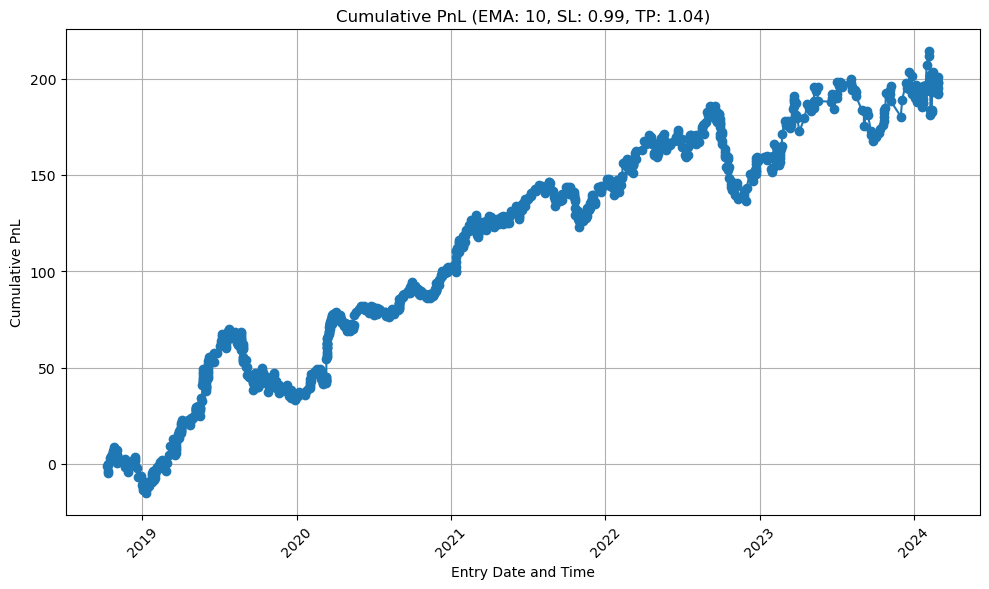

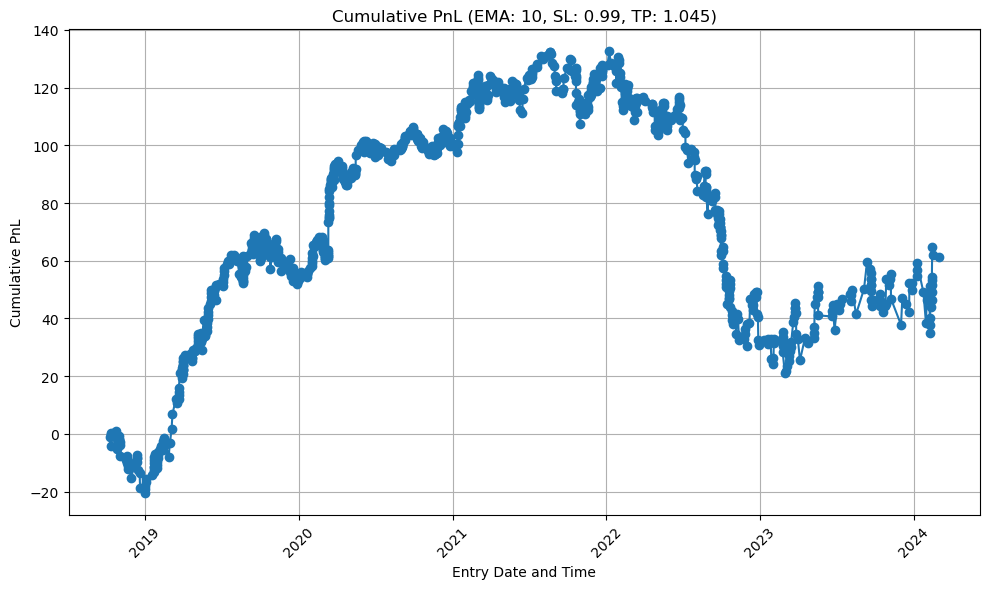

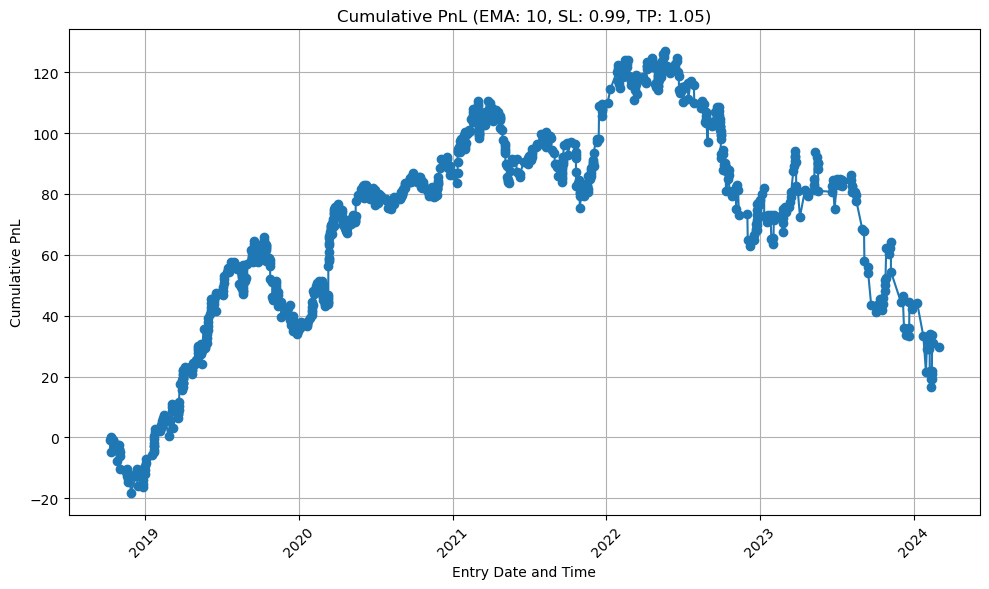

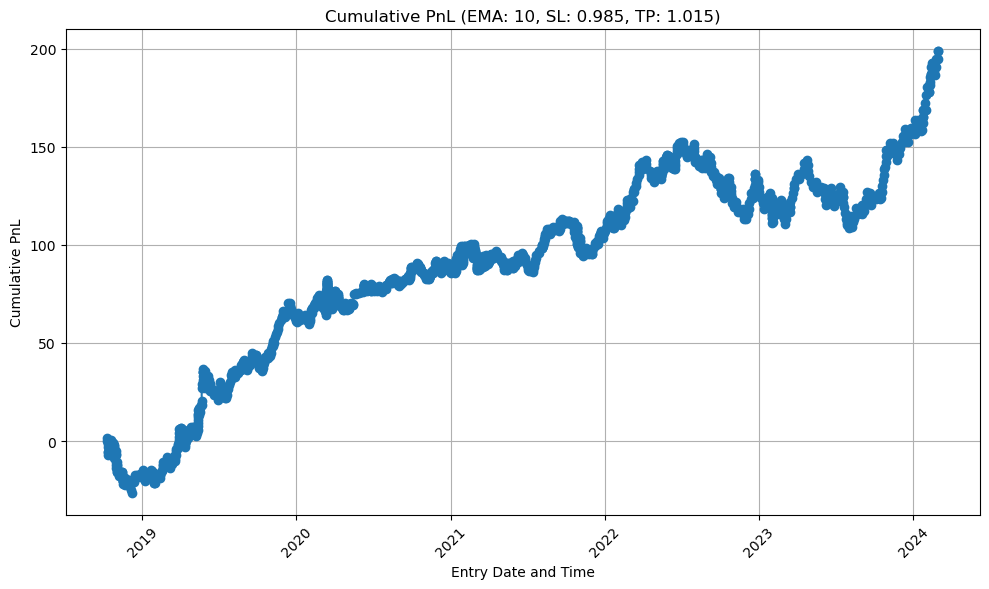

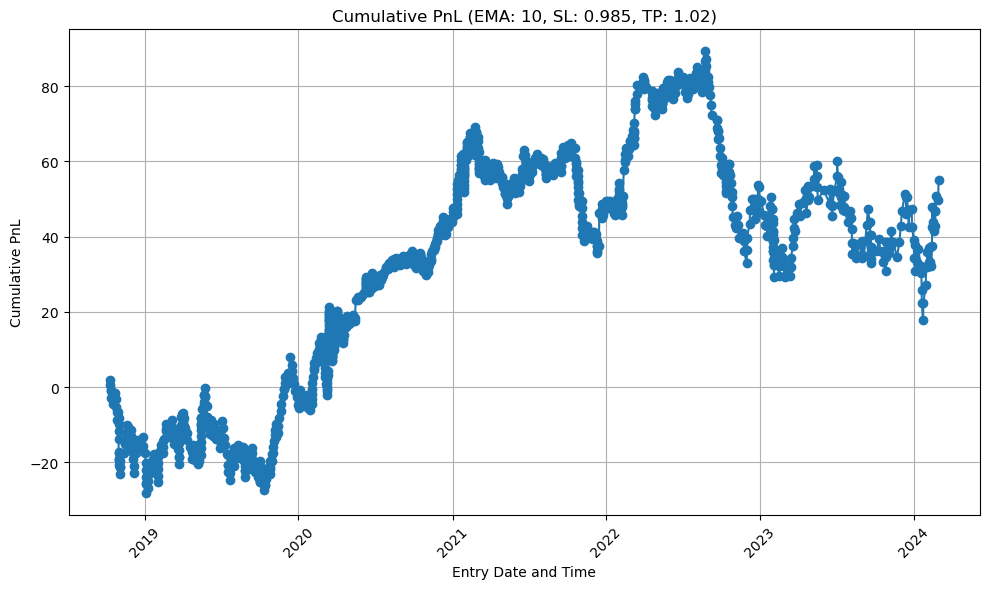

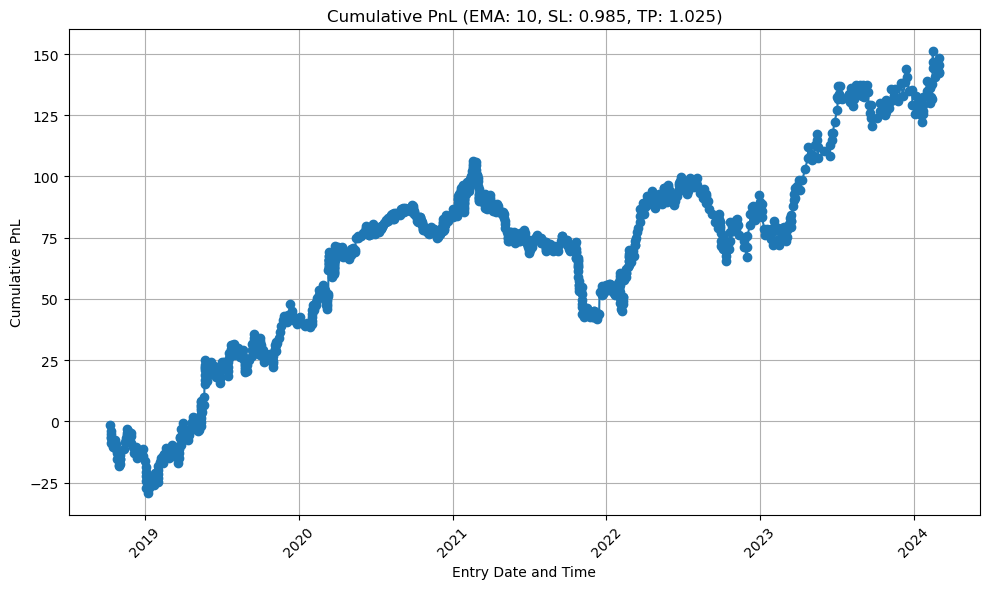

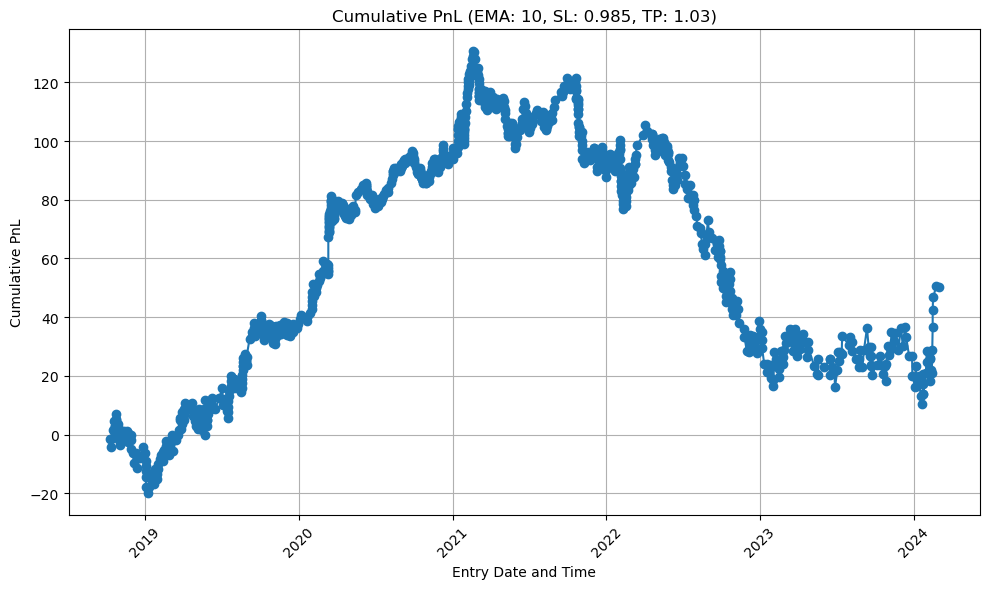

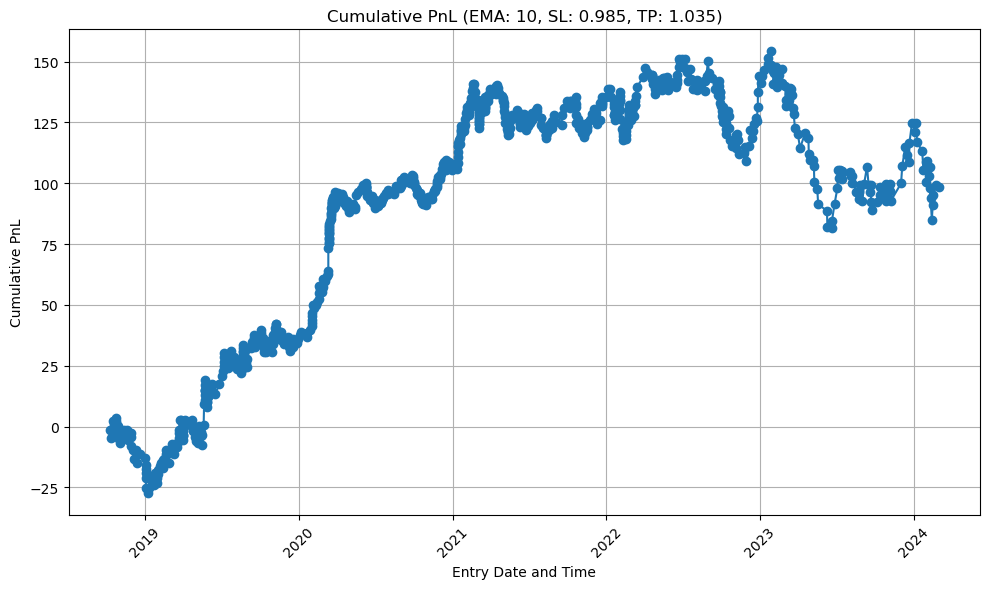

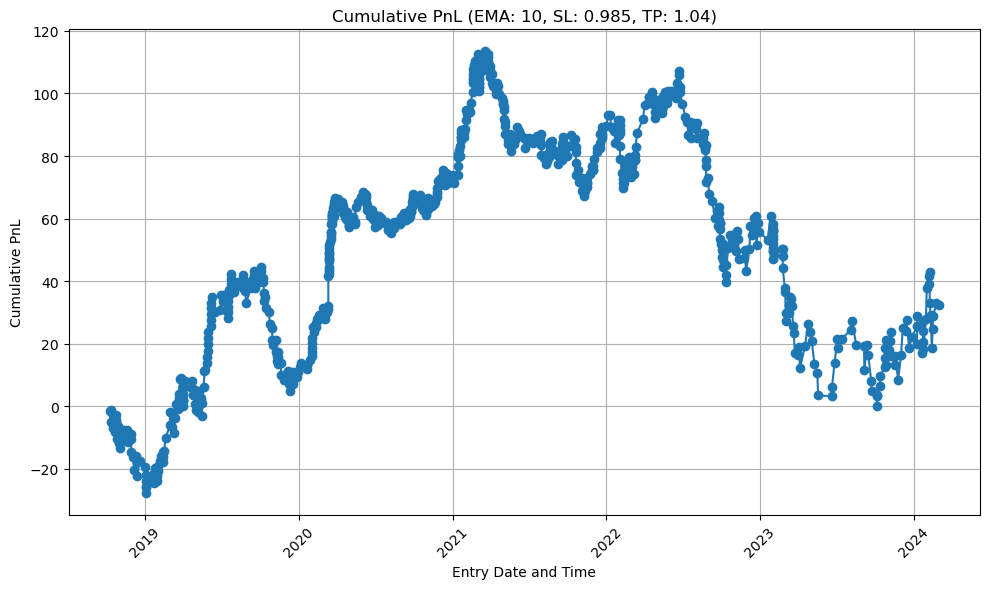

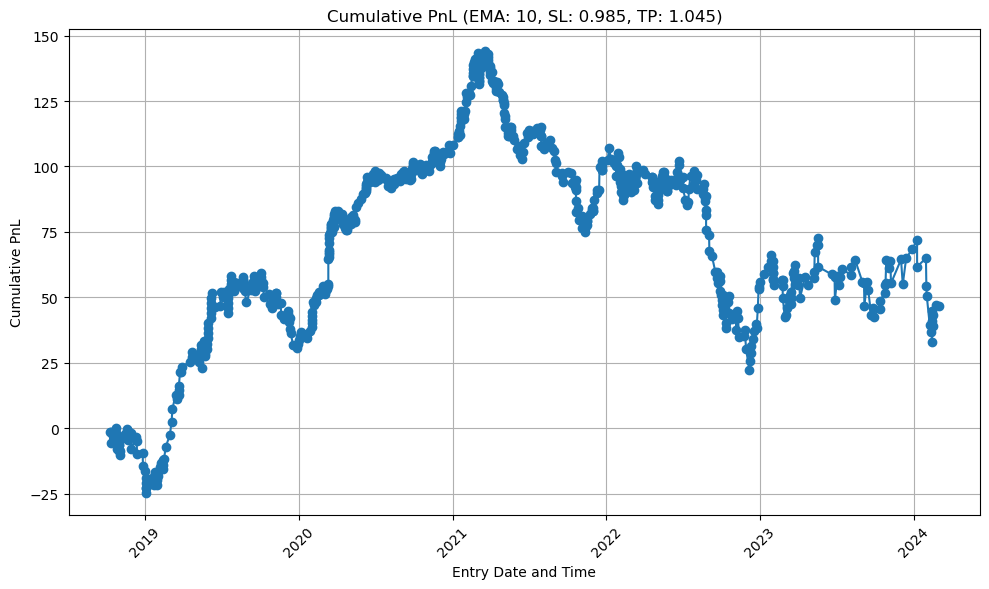

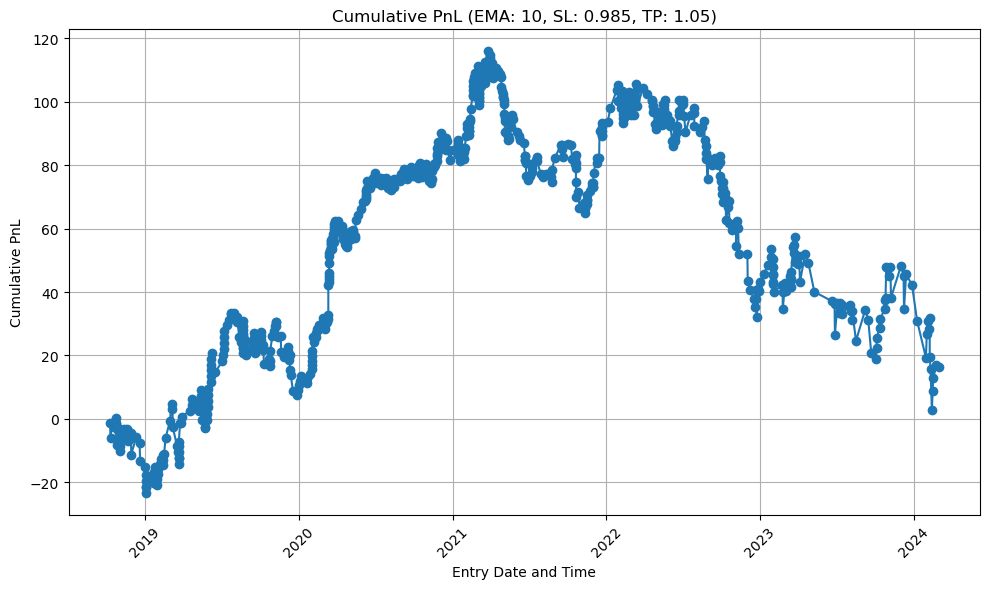

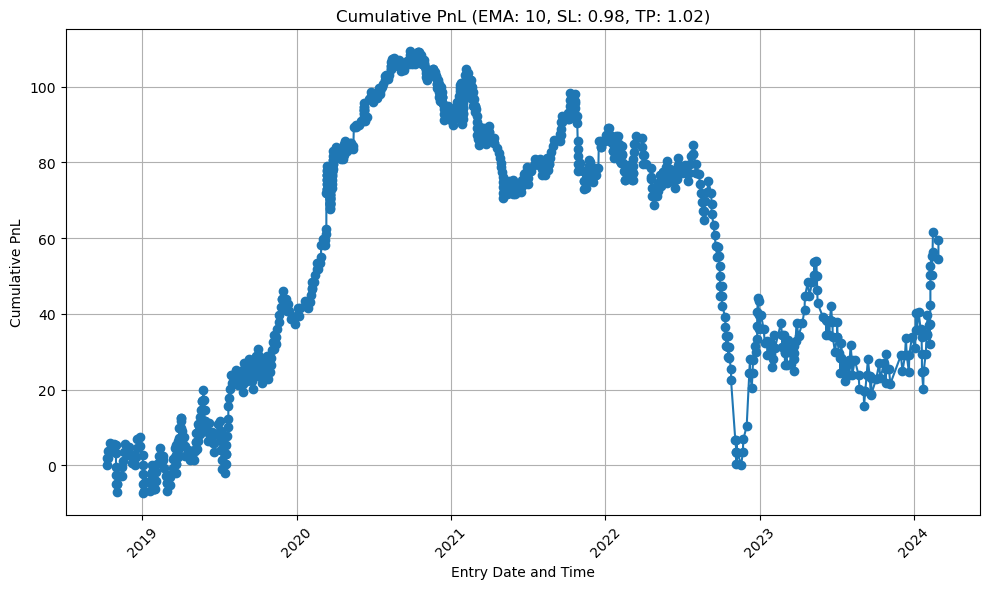

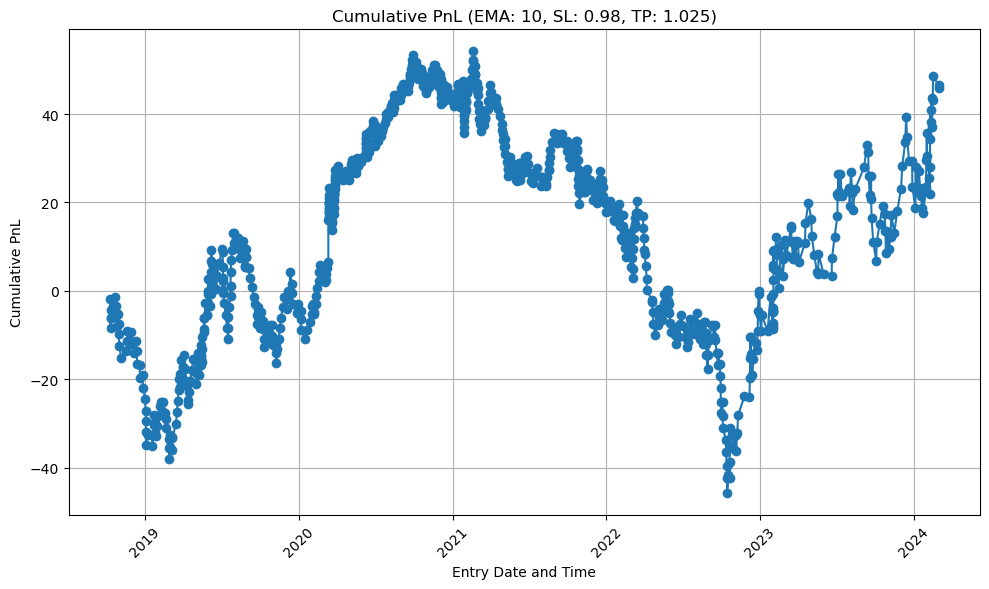

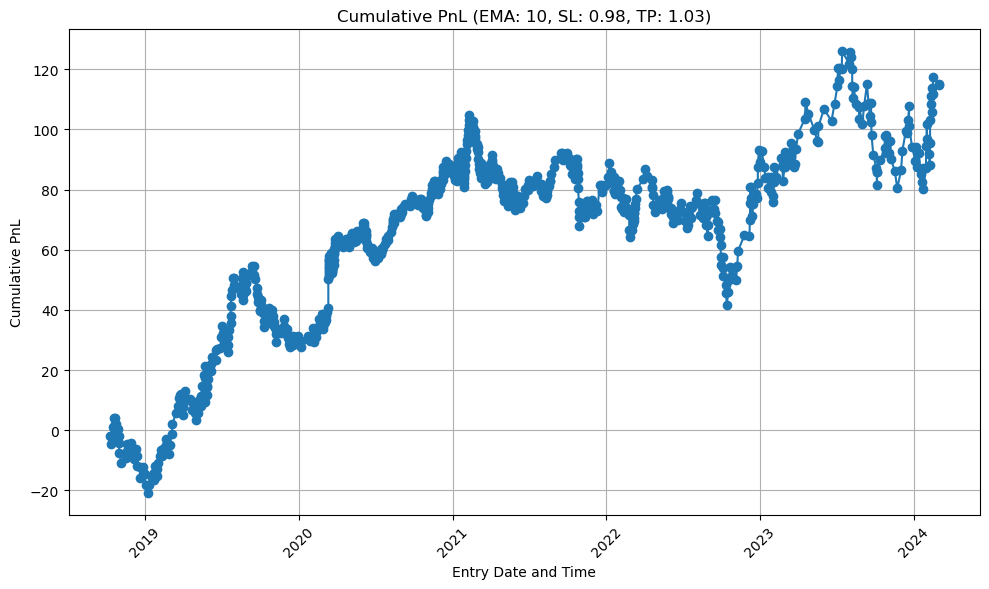

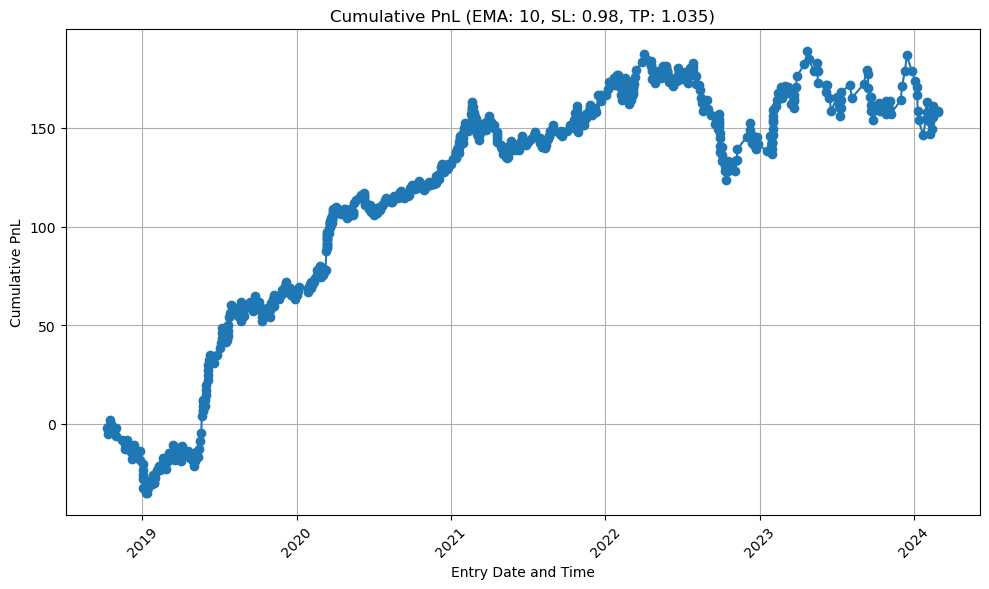

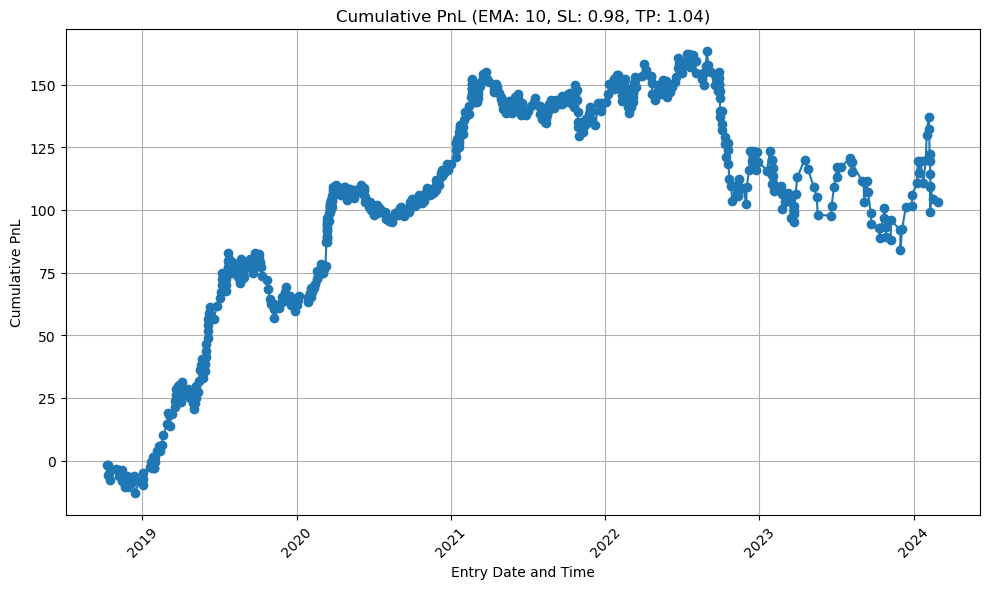

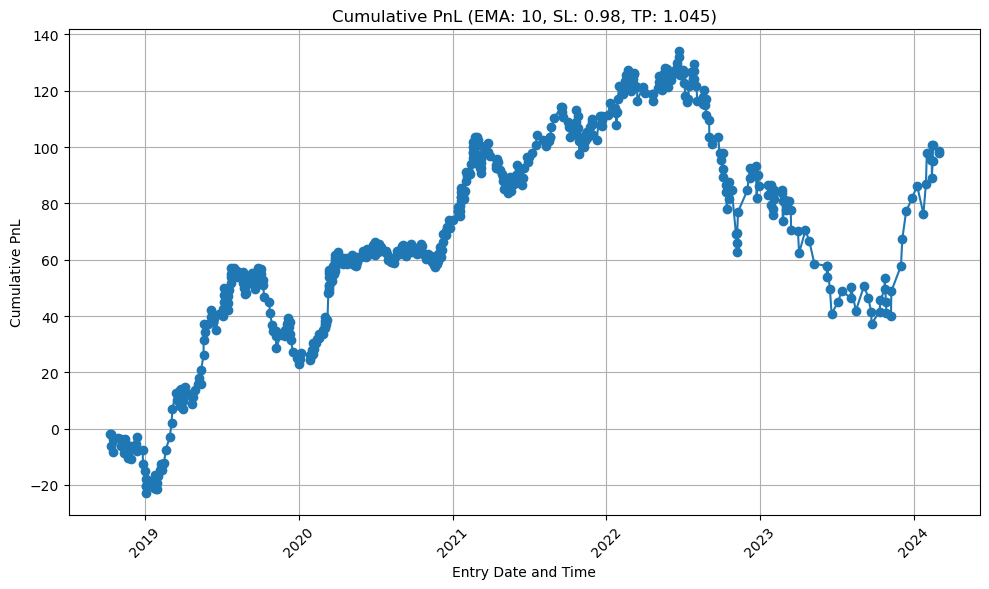

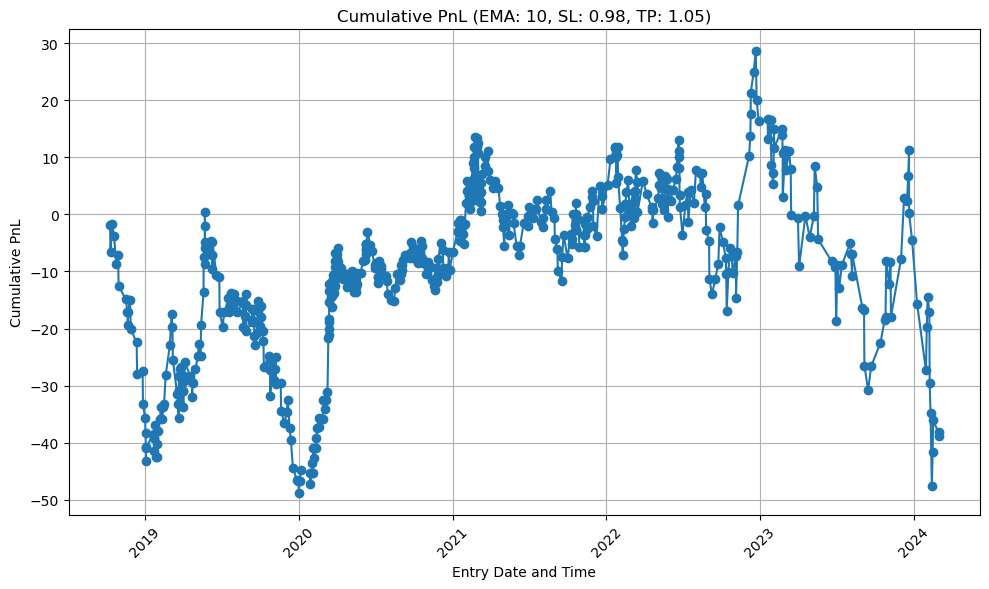

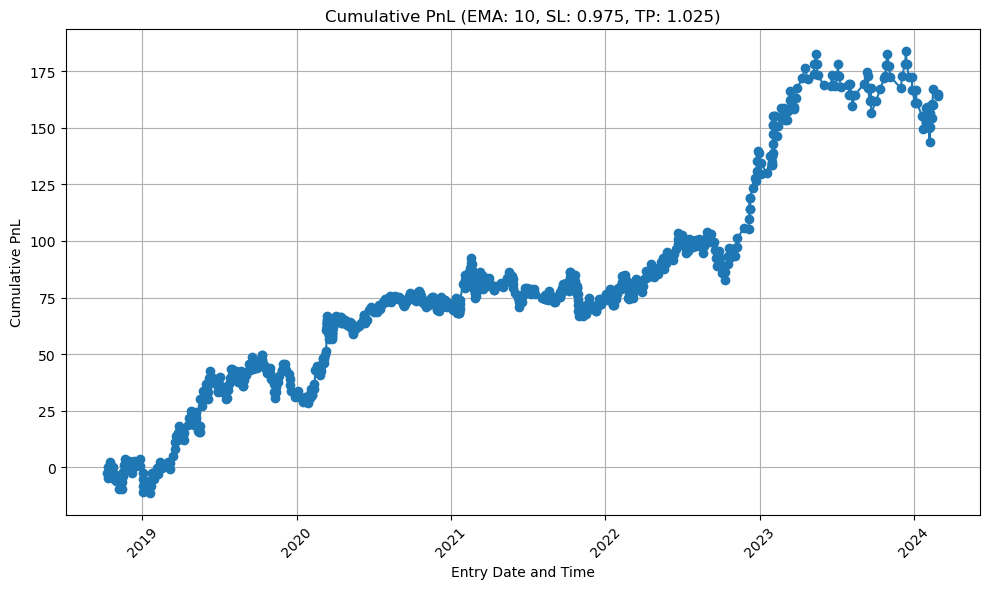

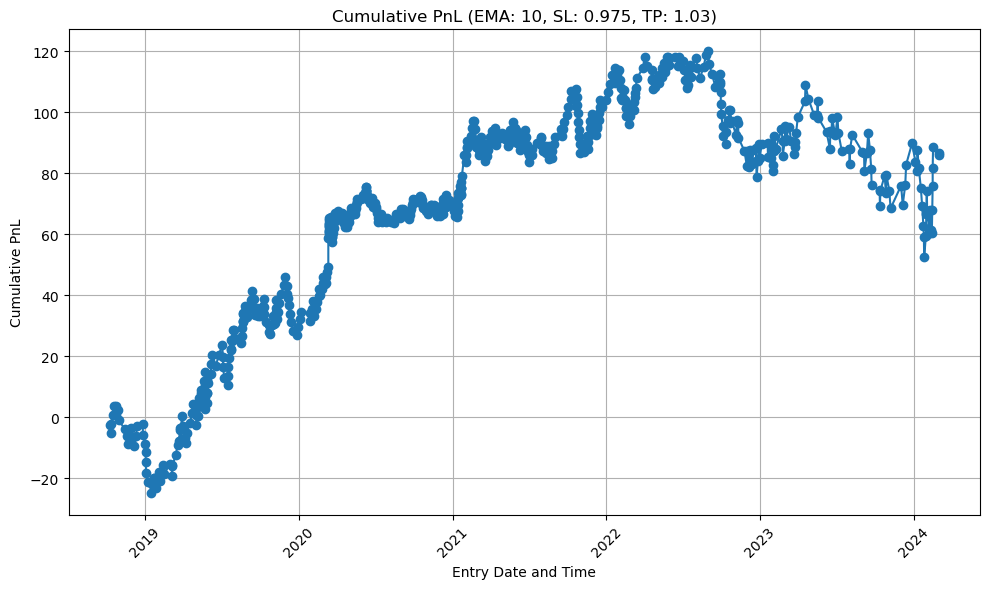

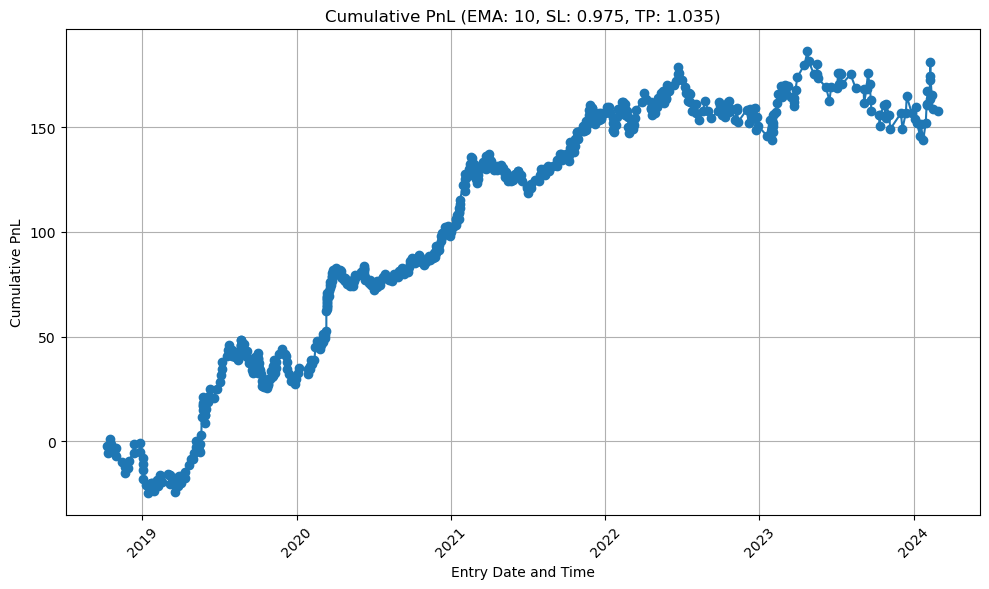

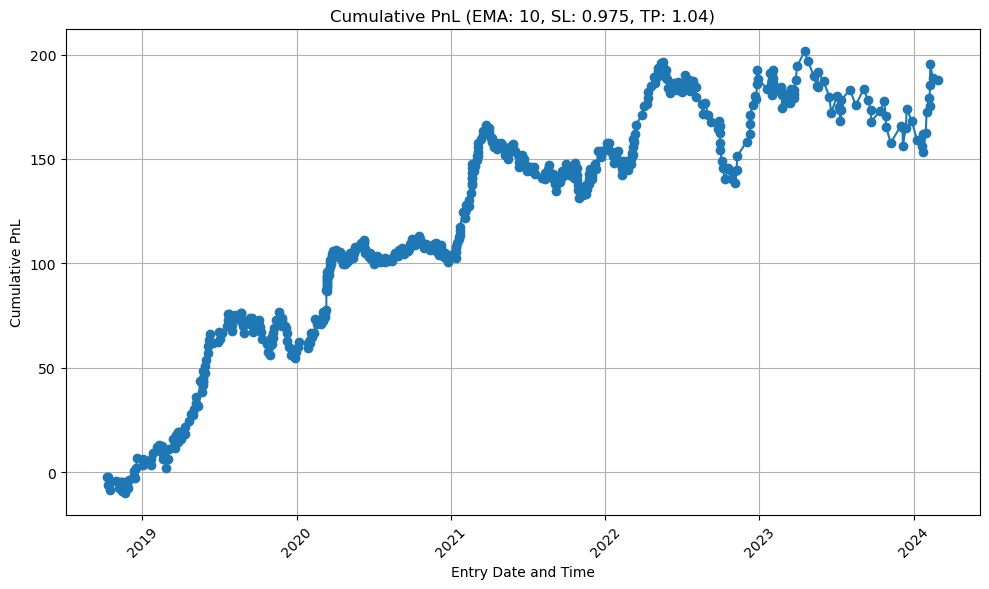

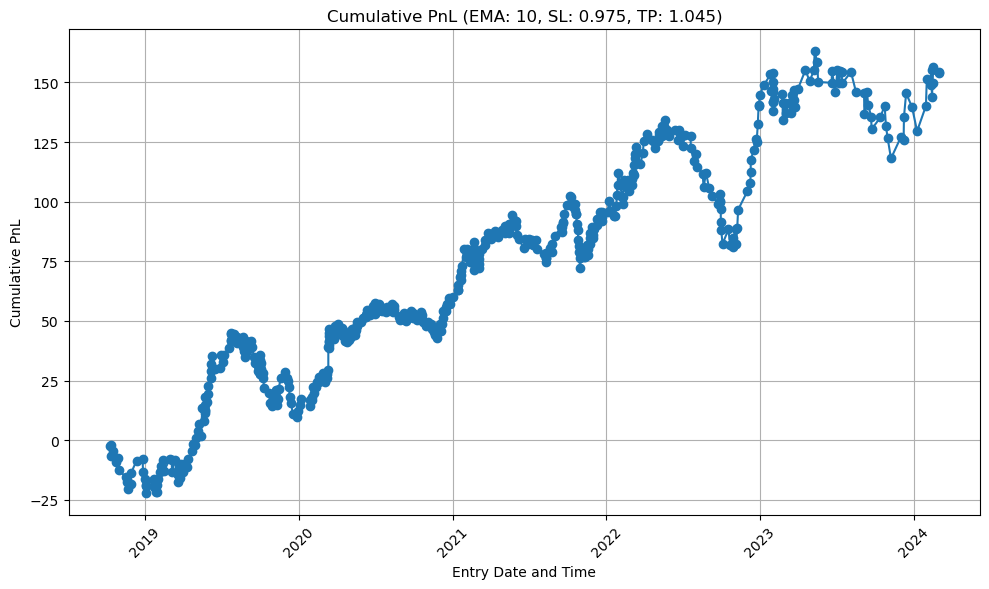

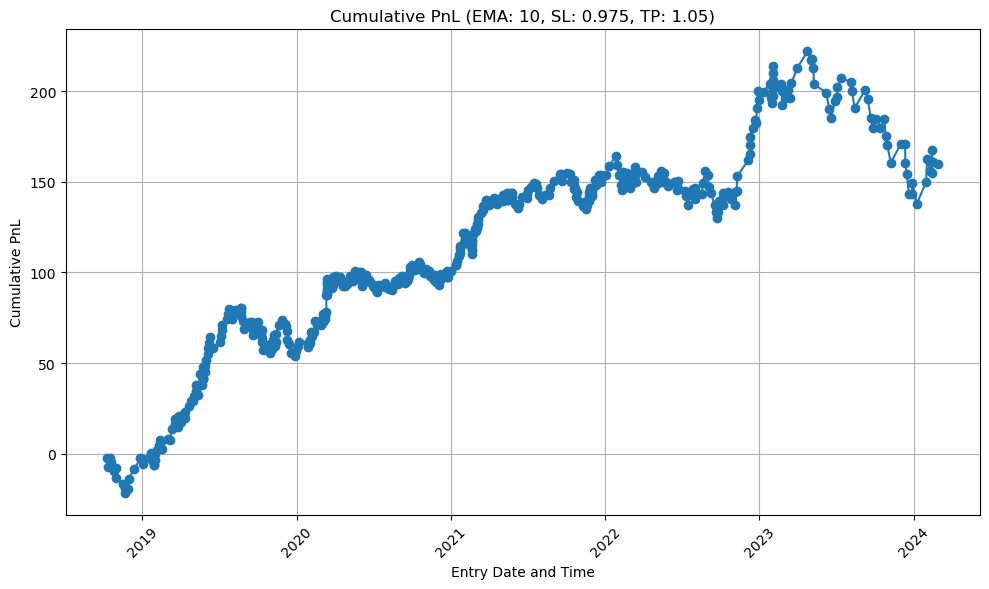

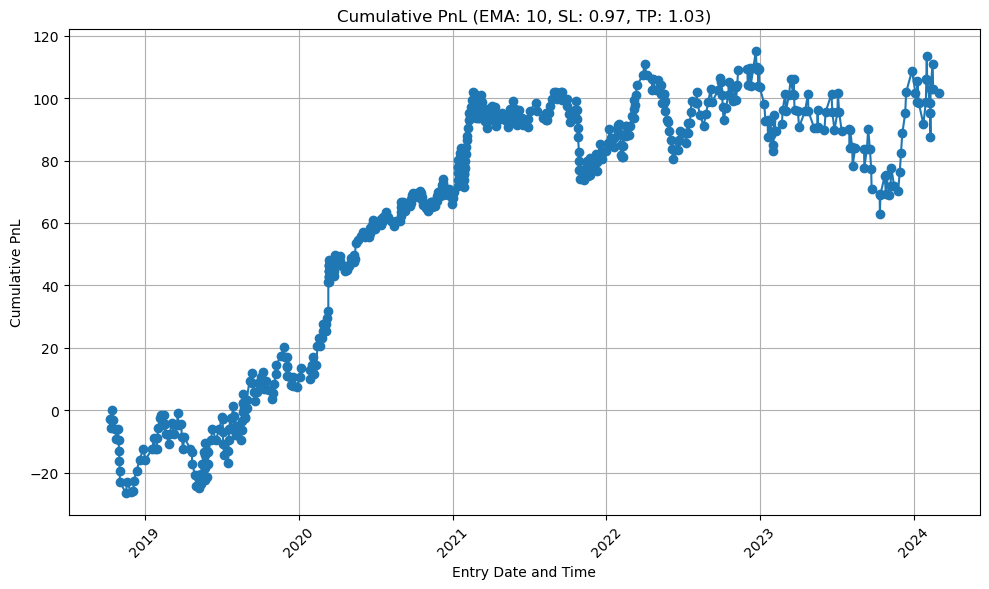

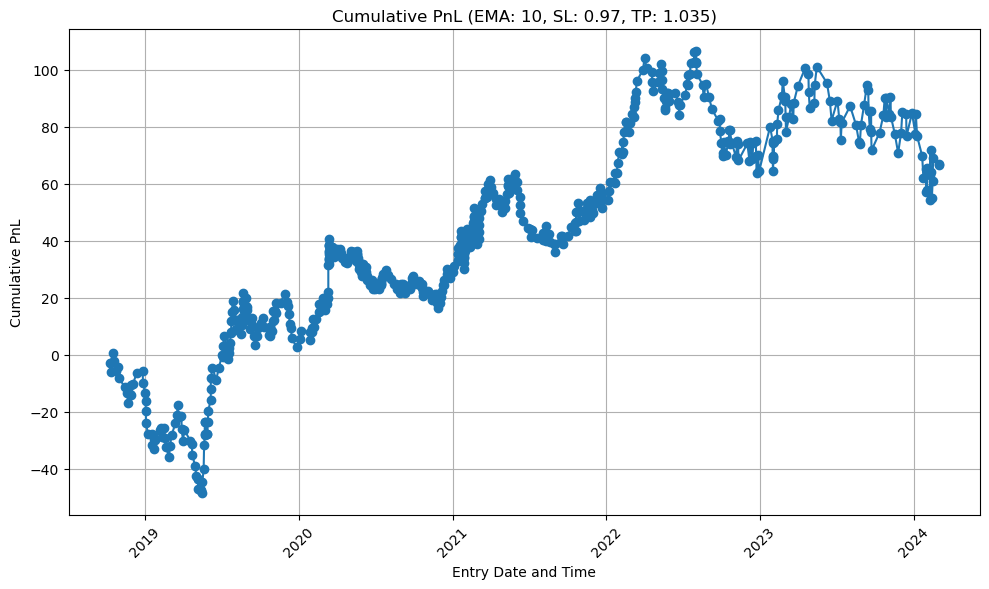

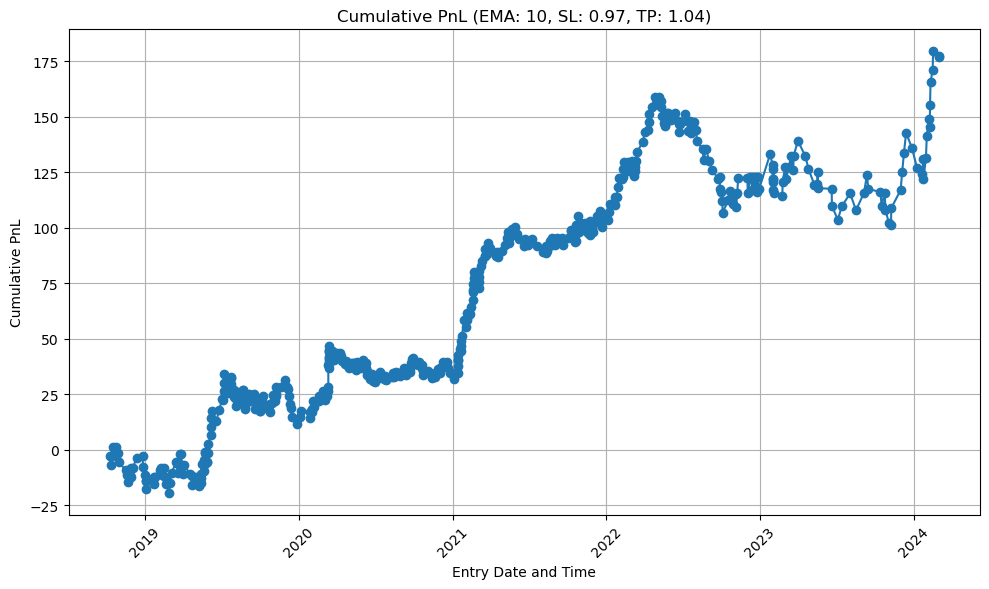

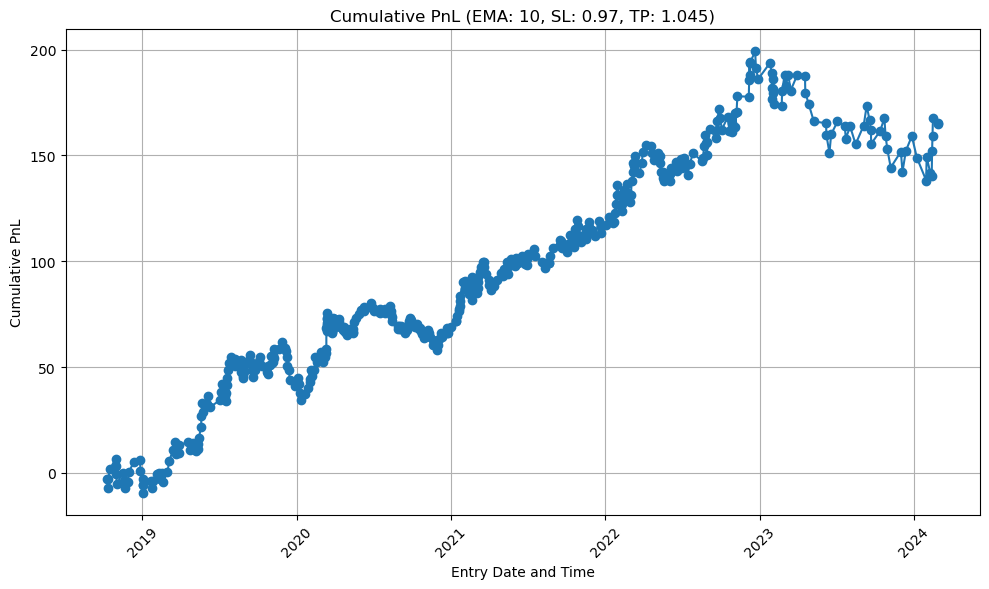

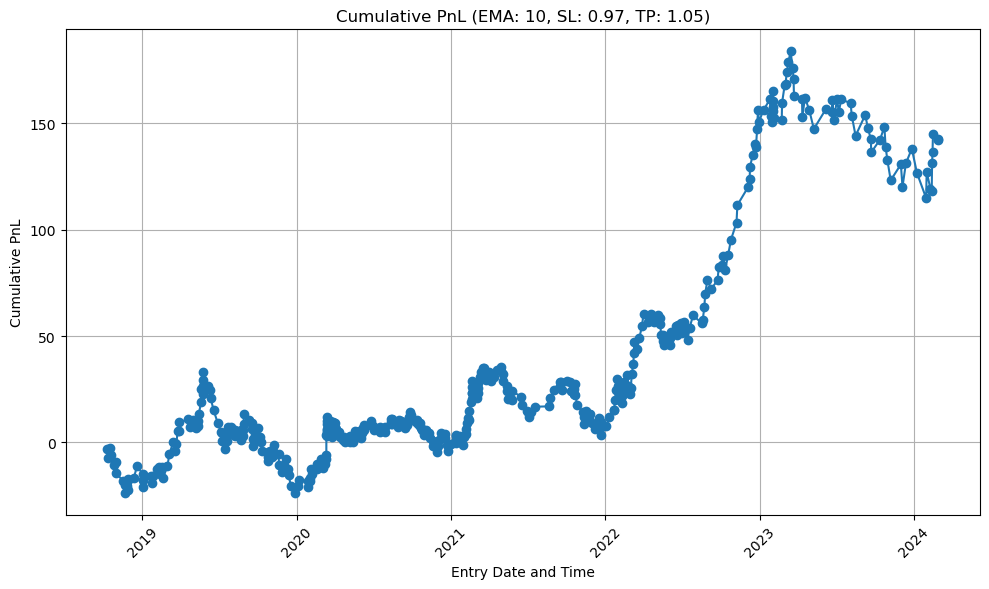

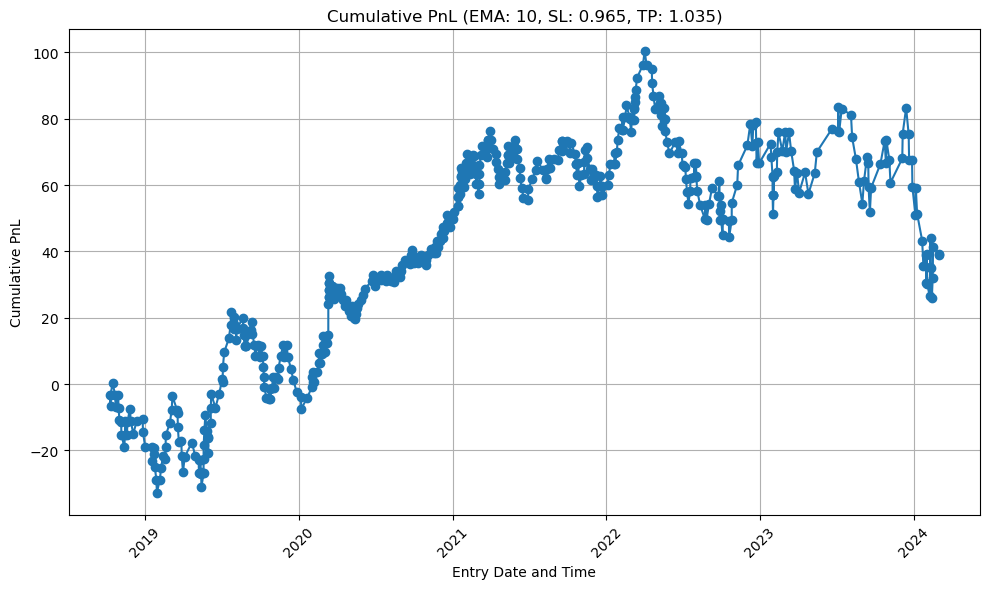

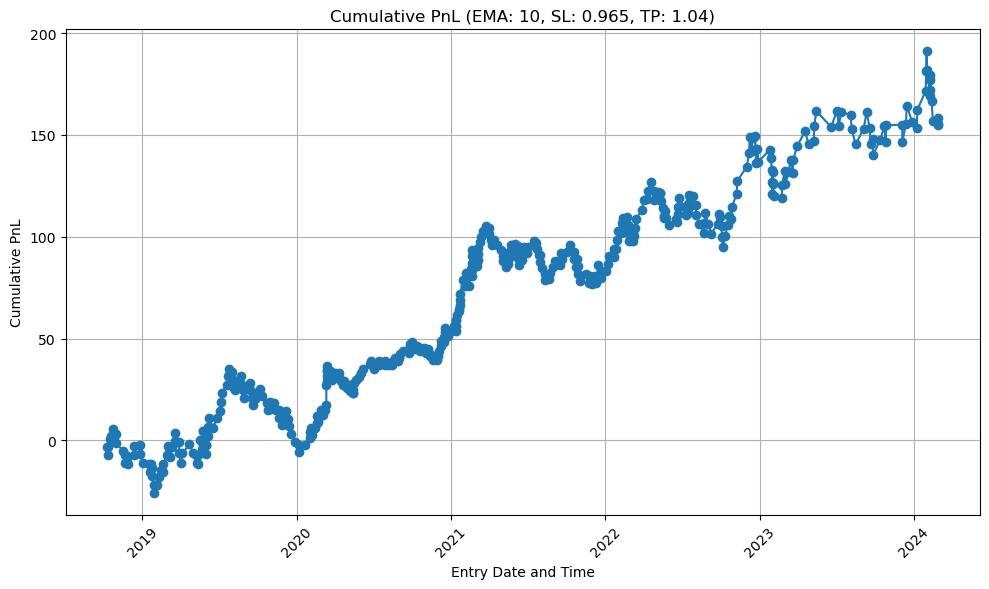

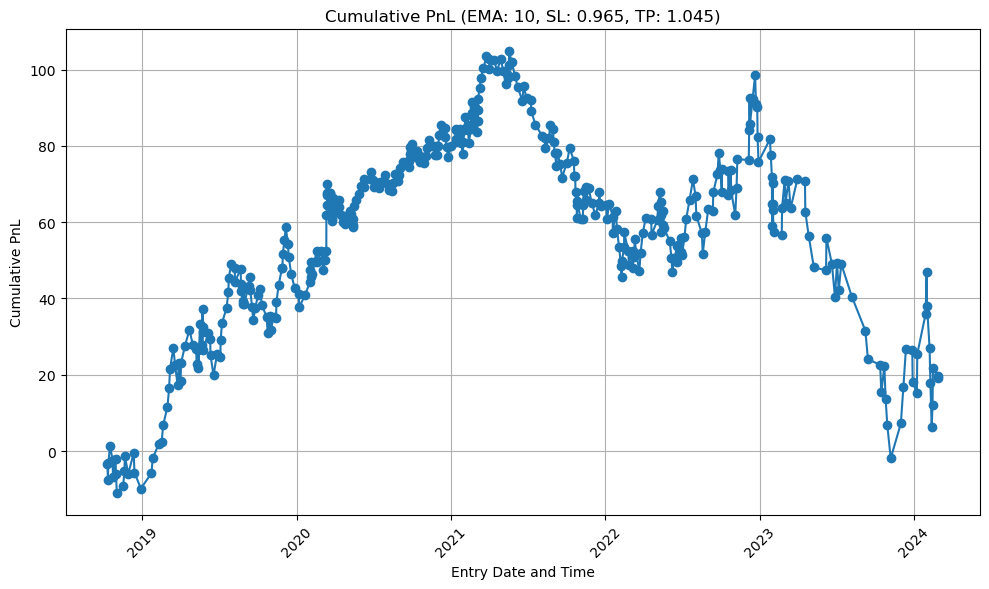

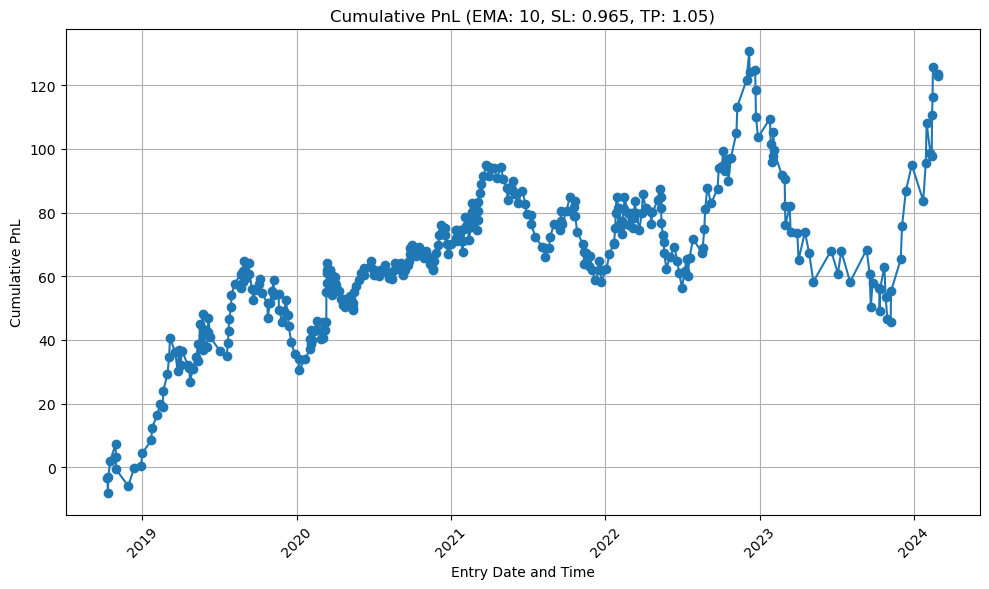

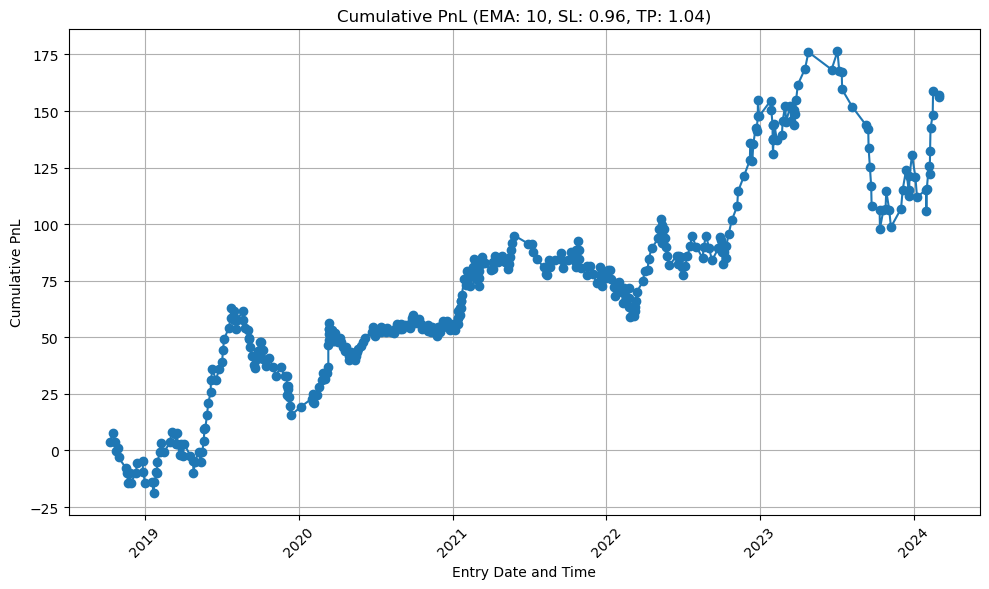

In [2]:
##################  Define the function to load the data ##################
def process_trading_data(base_dir, ema_span):
    # Load the data
    df_spot = pd.read_csv(os.path.join(base_dir, "bankbaroda_spot_data.csv")).drop(columns=['Unnamed: 0'])
    df_future = pd.read_csv(os.path.join(base_dir, "bankbaroda_future_data.csv"))

    # Calculate EMA for high and low prices
    df_spot['ema_high'] = df_spot['high'].ewm(span=ema_span, adjust=False).mean().round(2)
    df_spot['ema_low'] = df_spot['low'].ewm(span=ema_span, adjust=False).mean().round(2)

    # Initialize 'signal' column with a compatible dtype (object)
    df_spot['signal'] = 0
    df_spot['signal'] = df_spot['signal'].astype('object')

    # Find the indices where the close price is greater than the EMA high
    buy_indices = df_spot[df_spot['close'] > df_spot['ema_high']].index
    sell_indices = df_spot[df_spot['close'] < df_spot['ema_low']].index

    # Update the 'signal' column with 'BUY' and 'SELL' at the respective indices
    df_spot.loc[buy_indices, 'signal'] = 'BUY'
    df_spot.loc[sell_indices, 'signal'] = 'SELL'

    # Apply forward fill to propagate the last valid observation forward
    df_spot['signal'] = df_spot['signal'].replace(0, None).ffill()
    df_spot['signal'] = df_spot['signal'].shift(1)
    # Filter out rows where 'signal' is None or 0
    df_spot = df_spot[df_spot['signal'].isin(['BUY', 'SELL'])]

    # Create combined key columns
    df_spot['key'] = df_spot['date'].astype(str) + ' ' + df_spot['time'].astype(str)
    df_future['key'] = df_future['date'].astype(str) + ' ' + df_future['time'].astype(str)

    # Find the intersection of keys between df_spot and df_future
    common_keys = df_spot['key'].isin(df_future['key'])

    # Filter df_spot to keep only rows with common keys
    df_spot = df_spot[common_keys]

    # Merge the filtered spot and future DataFrames on the combined key
    merged_df = pd.merge(df_spot[['key', 'signal']], df_future[['key', 'open']], on='key', how='inner')

    # Map signals to trades
    merged_df['Trade'] = merged_df['signal'].map({'BUY': 'BUY', 'SELL': 'SELL'})

    # Create the final DataFrame with the desired columns
    filtered_df = merged_df[['Trade', 'key', 'open']].rename(columns={
        'key': 'Entry_date_Entry_time',
        'open': 'Entry_price'
    })

    # Split 'Entry_date_Entry_time' into 'Entry_date' and 'Entry_time'
    filtered_df[['Entry_date', 'Entry_time']] = filtered_df['Entry_date_Entry_time'].str.split(' ', expand=True)
    filtered_df = filtered_df.drop(columns=['Entry_date_Entry_time'])

    # Sort by 'Entry_date' and 'Entry_time'
    filtered_df = filtered_df.sort_values(by=['Entry_date', 'Entry_time']).reset_index(drop=True)

    # Reorder columns to match the original output
    filtered_df = filtered_df[['Trade', 'Entry_date', 'Entry_time', 'Entry_price']]

    return filtered_df, df_future

#################### Define the function to apply takeprofit and stoploss ####################
def calculate_takeprofit_stoploss(df, takeprofit_multiplier, stoploss_multiplier):
    """
    Calculate takeprofit and stoploss prices based on trade type.

    Parameters:
    df (pd.DataFrame): DataFrame containing trade information with columns 'Trade' and 'Entry_price'.
    takeprofit_multiplier (float): Multiplier for calculating the takeprofit price.
    stoploss_multiplier (float): Multiplier for calculating the stoploss price.

    Returns:
    pd.DataFrame: Updated DataFrame with 'takeprofit_price' and 'stoploss_price' columns.
    """
    df['takeprofit_price'] = np.where(
        df['Trade'] == 'BUY',
        df['Entry_price'] * takeprofit_multiplier,
        df['Entry_price'] * stoploss_multiplier
    )

    df['stoploss_price'] = np.where(
        df['Trade'] == 'BUY',
        df['Entry_price'] * stoploss_multiplier,
        df['Entry_price'] * takeprofit_multiplier
    )

    return df
################################# Define the function to get exit trade details #################################
def process_trades(filtered_df, df_future):
    """
    Process trades to determine exit points and apply conditions.
    """
    filtered_df['exit_date'] = None
    filtered_df['exit_time'] = None
    filtered_df['exit_price'] = 0.0
    filtered_df['trade_statement'] = None

    entry_price_lookup = df_future.set_index(['date', 'time'])['open'].to_dict()

    for idx, row in filtered_df.iterrows():
        entry_date = row['Entry_date']
        entry_time = row['Entry_time']
        trade_type = row['Trade']

        entry_key = (entry_date, entry_time)
        entry_price = entry_price_lookup.get(entry_key, None)
        if entry_price is not None:
            filtered_df.at[idx, 'Entry_price'] = entry_price

        condition = (df_future['date'] >= entry_date) & (df_future['time'] > entry_time)
        for idx_future, row_future in df_future[condition].iterrows():
            if trade_type == 'BUY':
                if row_future['high'] >= row['takeprofit_price']:
                    filtered_df.at[idx, 'exit_date'] = row_future['date']
                    filtered_df.at[idx, 'exit_time'] = row_future['time']
                    filtered_df.at[idx, 'exit_price'] = row['takeprofit_price']
                    filtered_df.at[idx, 'trade_statement'] = 'Take Profit'
                    break
                elif row_future['low'] <= row['stoploss_price']:
                    filtered_df.at[idx, 'exit_date'] = row_future['date']
                    filtered_df.at[idx, 'exit_time'] = row_future['time']
                    filtered_df.at[idx, 'exit_price'] = row['stoploss_price']
                    filtered_df.at[idx, 'trade_statement'] = 'Stop Loss'
                    break
            elif trade_type == 'SELL':
                if row_future['low'] <= row['takeprofit_price']:
                    filtered_df.at[idx, 'exit_date'] = row_future['date']
                    filtered_df.at[idx, 'exit_time'] = row_future['time']
                    filtered_df.at[idx, 'exit_price'] = row['takeprofit_price']
                    filtered_df.at[idx, 'trade_statement'] = 'Take Profit'
                    break
                elif row_future['high'] >= row['stoploss_price']:
                    filtered_df.at[idx, 'exit_date'] = row_future['date']
                    filtered_df.at[idx, 'exit_time'] = row_future['time']
                    filtered_df.at[idx, 'exit_price'] = row['stoploss_price']
                    filtered_df.at[idx, 'trade_statement'] = 'Stop Loss'
                    break

        if pd.isnull(filtered_df.at[idx, 'exit_date']):
            for idx_future in range(idx + 1, len(filtered_df)):
                if filtered_df.at[idx_future, 'Trade'] != trade_type:
                    filtered_df.at[idx, 'exit_date'] = filtered_df.at[idx_future, 'Entry_date']
                    filtered_df.at[idx, 'exit_time'] = filtered_df.at[idx_future, 'Entry_time']
                    filtered_df.at[idx, 'exit_price'] = filtered_df.at[idx_future, 'Entry_price']
                    filtered_df.at[idx, 'trade_statement'] = 'Signal Change'
                    break

    previous_exit_date = None
    previous_exit_time = None
    rows_to_keep = []

    for idx, row in filtered_df.iterrows():
        if previous_exit_date is not None and previous_exit_time is not None:
            if (row['Entry_date'] < previous_exit_date) or (row['Entry_date'] == previous_exit_date and row['Entry_time'] < previous_exit_time):
                continue

        rows_to_keep.append(idx)
        previous_exit_date = row['exit_date']
        previous_exit_time = row['exit_time']

    filtered_df = filtered_df.loc[rows_to_keep]
    filtered_df = filtered_df.dropna(subset=['exit_date', 'exit_time', 'exit_price'])

    return filtered_df


################################## Define the function to calculate MFE% and MAE% ##################################

def calculate_mfe_mae(filtered_df, df_future):
    """
    Calculate MFE (Maximum Favorable Excursion) and MAE (Maximum Adverse Excursion) for each trade.
    """
    filtered_df['mfe%'] = 0.0
    filtered_df['mae%'] = 0.0

    df_future['date_time'] = pd.to_datetime(df_future['date'] + ' ' + df_future['time'])

    for idx, row in filtered_df.iterrows():
        entry_date_time = pd.Timestamp(f"{row['Entry_date']} {row['Entry_time']}")
        exit_date_time = pd.Timestamp(f"{row['exit_date']} {row['exit_time']}")
        condition = (df_future['date_time'] >= entry_date_time) & (df_future['date_time'] <= exit_date_time)
        temp = df_future[condition]

        if not temp.empty:
            if row['Trade'] == 'BUY':
                mfe = temp['high'].max()
                mae = temp['low'].min()
                filtered_df.at[idx, 'mfe%'] = round((((mfe - row['Entry_price']) / row['Entry_price']) * 100), 2)
                filtered_df.at[idx, 'mae%'] = round((((mae - row['Entry_price']) / row['Entry_price']) * 100), 2)
            elif row['Trade'] == 'SELL':
                mfe = temp['low'].min()
                mae = temp['high'].max()
                filtered_df.at[idx, 'mfe%'] = round((((row['Entry_price'] - mfe) / row['Entry_price']) * 100), 2)
                filtered_df.at[idx, 'mae%'] = round((((row['Entry_price'] - mae) / row['Entry_price']) * 100), 2)
        else:
            print(f"No data found between {entry_date_time} and {exit_date_time} for index {idx}.")

    return filtered_df

################################## Define the function to calculate and save results ##################################

def calculate_and_save_results(filtered_df, sl, tp, ema_period, final_dir):
    filtered_df['pnl'] = 0.0
    for idx, row in filtered_df.iterrows():
        if row['Trade'] == 'BUY':
            filtered_df.at[idx, 'pnl'] = row['exit_price'] - row['Entry_price']
        elif row['Trade'] == 'SELL':
            filtered_df.at[idx, 'pnl'] = row['Entry_price'] - row['exit_price']

    filtered_df['cumulative_pnl'] = filtered_df['pnl'].cumsum()
    filtered_df['drawdown'] = filtered_df['cumulative_pnl'] - filtered_df['cumulative_pnl'].cummax()
    max_drawdown = filtered_df['drawdown'].min()
    # Combine Entry_date and Entry_time into a single datetime column
    filtered_df['Entry_datetime'] = pd.to_datetime(filtered_df['Entry_date'] + ' ' + filtered_df['Entry_time'])


    # Save results to Excel
    file_name = f"strategy_results_ema_{ema_period}_sl_{sl}_tp_{tp}.xlsx"
    with pd.ExcelWriter(os.path.join(final_dir, file_name)) as writer:
        filtered_df.to_excel(writer, sheet_name='Trade Details', index=False)
        summary_df = pd.DataFrame({
            'Total PnL': [filtered_df['pnl'].sum()],
            'Maximum Drawdown': [max_drawdown],
            'Take Profit Multiplier': [tp],
            'Stop Loss Multiplier': [sl],
            'EMA Period': [ema_period]
        })
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
    # Plotting cumulative PnL
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['Entry_datetime'], filtered_df['cumulative_pnl'], marker='o')
    plt.title(f'Cumulative PnL (EMA: {ema_period}, SL: {sl}, TP: {tp})')
    plt.xlabel('Entry Date and Time')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(final_dir, f"equity_curve_ema_{ema_period}_sl_{sl}_tp_{tp}.png"))
    plt.show()

################################################### Define Function to filter out combinations #####################################
def filter_combinations(stoploss_multiplier, takeprofit_multiplier):
    filtered_combinations = {}
    for i, sl in enumerate(stoploss_multiplier):
        # Filter the takeprofit_multiplier based on the index
        filtered_tp = takeprofit_multiplier[i:]
        filtered_combinations[sl] = filtered_tp

    return filtered_combinations


#################### Define the main script ####################
# Main script
if __name__ == "__main__":
    base_dir = r"C:\Users\arushi\OneDrive\Desktop\data_fol\15min_data\bankbaroda_data"
    final_dir = r"C:\Users\arushi\OneDrive\Desktop\results\fish_strategy\bankbaroda_results"

    ema_period_list = [10, 20, 30]

    # Given stoploss and takeprofit multipliers
    stoploss_multiplier = [0.99, 0.985, 0.98, 0.975, 0.97, 0.965, 0.96, 0.955, 0.95]
    takeprofit_multiplier = [1.01, 1.015, 1.02, 1.025, 1.03, 1.035, 1.04, 1.045, 1.05]

    # Filter the combinations
    filtered_combinations = filter_combinations(stoploss_multiplier, takeprofit_multiplier)

    for ema_period in ema_period_list:
        for sl, tp_list in filtered_combinations.items():
            for tp in tp_list:
                filtered_df, df_future = process_trading_data(base_dir, ema_period)
                filtered_df = calculate_takeprofit_stoploss(filtered_df, tp, sl)
                filtered_df = process_trades(filtered_df, df_future)
                filtered_df = calculate_mfe_mae(filtered_df, df_future)
                calculate_and_save_results(filtered_df, sl=sl, tp=tp, ema_period=ema_period, final_dir=final_dir)